# AI image detection
## Installing the required dependecies and importing

In [1]:
%pip install torch torchvision torchaudio pandas scikit-learn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


AMD Jaoks eraldi

In [2]:
%pip install torch-directml --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Subset

## Data manipulation
Here we start off by loading in data from a csv file. Then we create an ImageDataset class to handle getting the images and subsequently manipualte those images to make training less cost expensive in terms of compute time. We also create the training and test sets.

Load data and define the ImageDataset

In [4]:

train_df = pd.read_csv("dataset/train.csv")
test_df  = pd.read_csv("dataset/test_v2_labels.csv")
test_df=test_df.rename(columns={"id": "file_name"})
train_df.head()
print(train_df['label'].unique())
print(train_df['label'].dtype)


[1 0]
int64


In [5]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform #save the dataframe, imagedirectory and transform

    def __len__(self):
        return len(self.df) #rows in the df

    def __getitem__(self, idx):
        row = self.df.iloc[idx] #takes one row from the df and makes the image path for it, open the image and convert to rgb
        img_path = os.path.join(self.img_dir, row["file_name"])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(row["label"], dtype=torch.float) #creates a label and changes it to a pytorch tensor

        if self.transform:
            image = self.transform(image) #use the transform

        return image, label

Manipulating images

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), #resize image to 256x256px
    transforms.RandomHorizontalFlip(p=0.5), # random right or left flip for generalization
    transforms.RandomRotation(10), #turn of up to 10 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # image generalization for model robustness
    transforms.ToTensor(), #turns the image into a pytorch tensor and normalizes pixels from 0-1
])

Creating train and test sets

In [7]:
batchSize=96
subsetSize=0.6

In [8]:
train_dataset = ImageDataset(train_df, "dataset", transform) #load the training dataset,
test_dataset  = ImageDataset(test_df,  "dataset", transform)

# Take % of the training dataset
subset_size = int(subsetSize * len(train_dataset))
train_subset = Subset(train_dataset, range(subset_size))

# Take % of the test dataset
subset_size_test = int(subsetSize * len(test_dataset))
test_subset = Subset(test_dataset, range(subset_size_test))


train_loader = DataLoader(train_subset, batch_size=batchSize, shuffle=True) #for training take a batch of 32 images at once for faster training, and shuffle the images each epoch for generalization
test_loader  = DataLoader(test_subset,  batch_size=batchSize, shuffle=False) #For testing shuffle is turned off to get repetable results


Image shape: torch.Size([3, 256, 256])
Label: tensor(0.)


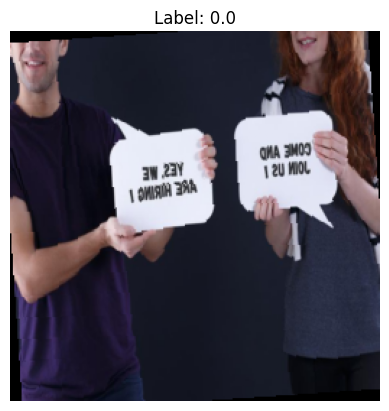

In [9]:
image, label = train_dataset[10001]   
print("Image shape:", image.shape)
print("Label:", label)
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label.item()}")
plt.axis("off")

plt.show()

## Creating a Pytorch CNN model

Device configuration

Amd

In [10]:
import torch_directml

device=torch_directml.device(1)
print("Device: ",device)

Device:  privateuseone:1


Nvidia/Muu

In [11]:
##device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

Device:  privateuseone:1


Hyperparameters

In [12]:
num_epochs = 30
learing_rate= 0.0005

Defining the Pytroch model<br>
Layers consist of conuvlution+relu and pooling for feature learning after which classification

In [13]:
class AiImageClassifier(nn.Module):
    def __init__ (self):
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=3, #3 input channels rgb
                      out_channels=32, # 32 feature maps
                      kernel_size=3, # 3x3 patch of the image
                      padding=1), #padding so outputs the same as input
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2=nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),   # looks for patterns
            nn.BatchNorm2d(64),
            nn.ReLU(),                      # makes the model non linear
            nn.MaxPool2d(2)                 # Shrinks the image, keeping strong signals
        )
        self.conv_block3=nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block4=nn.Sequential(
            nn.Conv2d(128,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.pooling=nn.AdaptiveAvgPool2d((1,1))

        self.fc1=nn.Linear(256,128) # 256 features into 128
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(0.5) # for overfitting
        self.fc2=nn.Linear(128,1) # single layer for binary classificiation
        # self.sigmoid=nn.Sigmoid() # 0 or 1
        

    
    def forward(self, x):
        x=self.conv_block1(x)   # [batch, 32, 128, 128]
        x=self.conv_block2(x)   # [batch, 64, 64, 64]
        x=self.conv_block3(x)   # [batch, 128, 32, 32]
        x=self.conv_block4(x)
        x=self.pooling(x)
        x=x.view(x.size(0),-1)  # turns 3d feature map into 1D vector
        x=self.fc1(x)
        x=self.relu(x)
        x=self.dropout(x)           
        x=self.fc2(x)           # combines layers for final prediciton
        return x # returns 0 or 1

Training the model

In [ ]:
start_epoch=0
checkpoint_path="model_checkpoint.pth"

if os.path.exists(checkpoint_path):
    checkpoint=torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print("Loaded checkpoint, resuming from epoch:", start_epoch)
else:
    print("No checkpoint found starting from epoch 0")

In [ ]:
model=AiImageClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()# Binary Cross Entropy 
optimizer=optim.Adam(model.parameters(),lr=learing_rate) 

n_total_steps=len(train_loader) 
for epoch in range(start_epoch,num_epochs): 
    model.train() 
    running_loss=0 # track loss 
    
    # Looping over all batches in the training set 
    for i, (images,labels) in enumerate(train_loader): 
        images=images.to(device)
        labels=labels.float().unsqueeze(1).to(device) 
        
        #forward pass and computing loss 
        outputs=model(images)
        loss=criterion(outputs,labels)
        
        #backward and optimize 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        #update weights 
        running_loss+=loss.item()
        #print avg loss every 50 steps 
        #if (i+1)%50==0: 
            #print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}') 
    print(f'Epoch [{epoch+1}/{num_epochs}] finished, Average Loss: {running_loss / n_total_steps:.4f}') 

    checkpoint={
        'epoch':epoch,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'loss':running_loss
    }
    torch.save(checkpoint,checkpoint_path)

print('Finished training')

c:\Users\Andreas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:3244: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)


Epoch [1/30] finished, Average Loss: 0.2596
Epoch [2/30] finished, Average Loss: 0.1902
Epoch [3/30] finished, Average Loss: 0.1697
Epoch [4/30] finished, Average Loss: 0.1534
Epoch [5/30] finished, Average Loss: 0.1467
Epoch [6/30] finished, Average Loss: 0.1418
Epoch [7/30] finished, Average Loss: 0.1347
Epoch [8/30] finished, Average Loss: 0.1317
Epoch [9/30] finished, Average Loss: 0.1249
Epoch [10/30] finished, Average Loss: 0.1211
Epoch [11/30] finished, Average Loss: 0.1169
Epoch [12/30] finished, Average Loss: 0.1130
Epoch [13/30] finished, Average Loss: 0.1081
Epoch [14/30] finished, Average Loss: 0.1032
Epoch [15/30] finished, Average Loss: 0.1005
Epoch [16/30] finished, Average Loss: 0.0928
Epoch [17/30] finished, Average Loss: 0.0897
Epoch [18/30] finished, Average Loss: 0.0845
Epoch [19/30] finished, Average Loss: 0.0774
Epoch [20/30] finished, Average Loss: 0.0770
Epoch [21/30] finished, Average Loss: 0.0716
Epoch [22/30] finished, Average Loss: 0.0649
Epoch [23/30] finis

Calculating accuracy

In [15]:
model.eval()
all_labels=[]
predictions=[]
probabilities=[]

#no gradient computation
with torch.no_grad():
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.float().unsqueeze(1).to(device)
        
        outputs=model(images)
        probs=torch.sigmoid(outputs)
        preds=(probs > 0.35).int() #Probabilities to binary predicitons
        
        all_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

all_labels=np.array(all_labels).flatten()
predictions=np.array(predictions).flatten()
probabilities=np.array(probabilities).flatten()

acc=accuracy_score(all_labels,predictions)
prec=precision_score(all_labels,predictions)
rec=recall_score(all_labels,predictions)
f1=f1_score(all_labels,predictions)
cm=confusion_matrix(all_labels,predictions)
print("Number of predicitons?:",len(predictions))

print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec:.2f}")
print(f"Recall   : {rec:.2f}")
print(f"F1-score : {f1:.2f}")
print("Confusion Matrix:")
print(cm)

Number of predicitons?: 3324
Accuracy : 58.42%
Precision: 0.83
Recall   : 0.25
F1-score : 0.39
Confusion Matrix:
[[1504   91]
 [1291  438]]


Saving the model

In [16]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss
}

torch.save(checkpoint, "model_checkpoint.pth")
